In [ ]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot
from keras.models import load_model

In [ ]:
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dense
from tensorflow.python.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import files

files.upload()

Saving 상명대_전력수요예측_지수평활 sheet1.xlsx to 상명대_전력수요예측_지수평활 sheet1.xlsx


{'상명대_전력수요예측_지수평활 sheet1.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00\x9e,lok\x01\x00\x00\x10\x05\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [ ]:
# 데이터 입력 
import openpyxl
filename = "상명대_전력수요예측_지수평활 sheet1.xlsx" 
book = openpyxl.load_workbook(filename) #엑셀파일 book 변수에 저장
sheet=book.worksheets[0] #첫번쨰 워크시트 저장

In [ ]:
 data = []
 for row in sheet.rows: #전체 행에대하여 반복 실행
   data.append([
              row[0].value, #1열 데이터
              row[1].value, #2열 데이터
              row[2].value, #3열 데이터
              row[3].value, #4열 데이터
              row[4].value, #5열 데이터
              row[5].value  #6열 데이터
              ])

In [ ]:
import math
import pandas as pd
import numpy as np
data=pd.DataFrame(data[3:])
data.columns=["Name","No","Date","Time","P.D","Temp"]
data

,Name,No,Date,Time,P.D,Temp
0,신정,8,2018-01-01,1,6151.290,-3.2
1,신정,8,2018-01-01,2,6035.190,-3.3
2,신정,8,2018-01-01,3,6000.090,-3.7
3,신정,8,2018-01-01,4,5970.930,-4.0
4,신정,8,2018-01-01,5,6025.200,-4.2
...,...,...,...,...,...,...
8755,0,1,2018-12-31,20,7457.955,-3.7
8756,0,1,2018-12-31,21,7005.975,-4.6
8757,0,1,2018-12-31,22,6709.110,-5.4
8758,0,1,2018-12-31,23,6332.730,-5.2


In [ ]:
#계절
from datetime import date

date_=[]
a=len(data)
for i in range(0,a):
    month=data['Date'][i].month
    if(i<a and 3<=month<=5):
        date__='spring'
        date_.append(date__)
    elif(i<a and 6<=month<=8):
        date__='summer'
        date_.append(date__)
    elif(i<a and 9<=month<=11):
        date__='fall'
        date_.append(date__)
    elif(i<a and (month==12 or 2 or 1)):
        date__='winter'
        date_.append(date__)
data['season']=date_

# **계절 모델**

In [ ]:
#계절별 데이터 가져오기  
def find_season(W_season):
  is_season_data = data['season'] == W_season
  season_data = data[is_season_data]
  heat_data=season_data["P.D"]
  heat_data=pd.DataFrame(heat_data)
  heat_data = np.array(heat_data)
  return heat_data

In [ ]:
heat_data=find_season('winter')
number_of_whole_day = int(heat_data.shape[0]/24)
print(f"Number of Whole day: {number_of_whole_day}")

# #하루를 예측하는 것이므로 하루를 제외한 나머지는 train+vald으로 지정
# number_of_trainval_day=number_of_whole_day-1
# print(f"Number of train and validation day: {number_of_trainval_day}")

#train+val에서 80%를 훈련셋으로 지정  
number_of_train_day = int(number_of_whole_day * 0.8) 
print(f"Number of train day: {number_of_train_day}")

Number of Whole day: 90
Number of train day: 72


In [ ]:
#train_data중에서 
train_data=heat_data[:number_of_train_day*24]
print(f"Number of train data: {train_data.shape}")

# valid_data=heat_data[number_of_train_day*24:-24]
# print(f"Number of validation data: {valid_data.shape}")

test_data = heat_data[-24:]
print(f"Number of test data: {test_data.shape}")

Number of train data: (1728, 1)
Number of test data: (24, 1)


In [ ]:
#데이터 전처리 
#이유1.LSTM내부적으로 선형 결합의 결과값을 활성화 함수를 거치는데, 
#이때 입력값을 0과 1사이로 만든다. 입력값을 0과 1사이로 만들지 않는다면 
#그레디언트 소실이 발생할 가능성이 커짐.

#이유2.입력 특성이 두가지 이상인 경우, 두 특성의 범위가 많이 다르면 모델성능 떨어짐.

minmax_scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
#데이터 스케일링(0,1 사이값으로 변환)
min_max_normalized_train_data=minmax_scaler.fit_transform(train_data)

#fit은 사용하면 안됨.train data에서 fit했던 기준들을 이용해야하기 때문
# min_max_normalized_valid_data = minmax_scaler.transform(valid_data)
min_max_normalized_test_data = minmax_scaler.transform(test_data)

#스케일링된 결과
print(min(train_data), max(train_data))
print(min(min_max_normalized_train_data), max(min_max_normalized_train_data))

[1500.] [12434.595]
[0.] [1.]


In [ ]:
#numpy를 pandas로 변환
min_max_normalized_train_data = pd.DataFrame(min_max_normalized_train_data)[0]
# min_max_normalized_valid_data = pd.DataFrame(min_max_normalized_valid_data)[0]
min_max_normalized_test_data = pd.DataFrame(min_max_normalized_test_data)[0]

In [ ]:
#학습데이터, 결과데이터 배열로 return  
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    start = sequence.index.start
    for i in range(start, len(sequence)+start):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > start + len(sequence)-1:
            break
        # gather input and output parts of the pattern
        if start > 90:
            a = i - start
            b = end_ix - start
        else:
            a = i
            b = end_ix
        # seq_x, seq_y = sequence[a:b], sequence[end_ix]
        seq_x, seq_y = sequence[a:b], sequence[b]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
#데이터 split을 위한 값. 2개의 input, 1개의 result   
## Ex) [1, 2, 3, 4, 5], n_steps = 2 -> [[1, 2, [3]], [2, 3, [4]], [3, 4, [5]]]

n_step = 2

x_train, y_train = split_sequence(min_max_normalized_train_data, n_step)
# x_valid, y_valid = split_sequence(min_max_normalized_valid_data, n_step)
x_test, y_test = split_sequence(min_max_normalized_test_data, n_step)

print(x_train.shape)
print(y_train.shape)

(1726, 2)
(1726,)


In [ ]:
#RNN- 데이터 형변환 [samples, timesteps, features]
n_features = 1
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
# x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], n_features))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))

print(x_train.shape)  #shape=(2,1) 934개 
print(y_train.shape)  #정답

(1726, 2, 1)
(1726,)


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/PowerModel/LSTM_MODEL")

In [ ]:
#모델 정의
#모델 성능(오류율이 5%미만이면 break, 아니면 10번 시도 후에 break)
i = 0
while True and i < 10:
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_step, n_features)))  #input_shape=(2,1)
    model.add(LSTM(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    #model training start
    model.fit(x_train, y_train,epochs=350, batch_size=100, verbose=1) ; 

    #학습모델로 test data 예측  
    yhat = model.predict(x_test, verbose=0)
    yhat = minmax_scaler.inverse_transform(yhat)  #원래값으로 변경
    #Mean absolute percentage error - https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    result = np.mean(abs(test_data[n_step:] - yhat)/test_data[n_step:]) #test_data[n_step:]=test데이터[0],[1]의 y_train값
    if result*100 < 5:
      
      break
    else:
      del model
      i+=1

Epoch 1/350
18/18 [==============================] - 5s 13ms/step - loss: 0.3855
Epoch 2/350
18/18 [==============================] - 0s 13ms/step - loss: 0.2876
Epoch 3/350
18/18 [==============================] - 0s 14ms/step - loss: 0.1179
Epoch 4/350
18/18 [==============================] - 0s 14ms/step - loss: 0.0156
Epoch 5/350
18/18 [==============================] - 0s 13ms/step - loss: 0.0122
Epoch 6/350
18/18 [==============================] - 0s 12ms/step - loss: 0.0112
Epoch 7/350
18/18 [==============================] - 0s 13ms/step - loss: 0.0098
Epoch 8/350
18/18 [==============================] - 0s 14ms/step - loss: 0.0095
Epoch 9/350
18/18 [==============================] - 0s 13ms/step - loss: 0.0090
Epoch 10/350
18/18 [==============================] - 0s 13ms/step - loss: 0.0077
Epoch 11/350
18/18 [==============================] - 0s 12ms/step - loss: 0.0081
Epoch 12/350
18/18 [==============================] - 0s 13ms/step - loss: 0.0077
Epoch 13/350
18/18 [=====

KeyboardInterrupt: ignored

In [ ]:
f=open('output.csv','w')
for i in range(len(x_test)):
  f.write(str(test_data[i+2][0])+','+str(yhat[i][0])+'\n')
f.close()

In [ ]:
# x_test=[1,2,3,4,5]
# yhat=[2,3,4,5,6]
# f=open('output.csv','w')
# for j in range(10):
#   for i in range(len(x_test)):
#     f.write(str(x_test[i])+','+str(yhat[i])+'\n')
# f.close()

In [ ]:
result = np.mean(abs(test_data[n_step:] - yhat)/test_data[n_step:])*100  #test_data[n_step:]=test데이터[0],[1]의 y_train값
print(result)

4.083036312863781


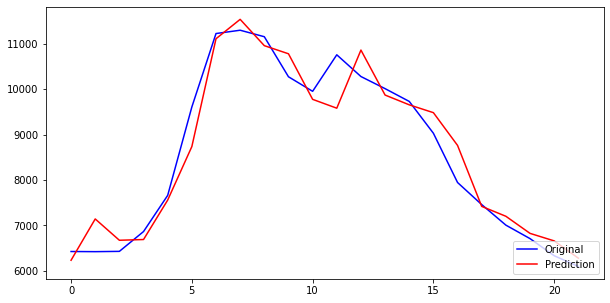

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(test_data[n_step:], 'b', label='Original')
ax1.plot(yhat, 'r', label='Prediction')
ax1.legend(loc="lower right")

# **전력+온도**

In [ ]:
#계절별 데이터 가져오기  
def find_season2(W_season):
  is_season_data = data['season'] == W_season
  season_data2 = data[is_season_data]
  columns = ['P.D', 'Temp']
  season_data2 = season_data2[columns]
  heat_data2=pd.DataFrame(season_data2)
  heat_data2['P.D']=pd.to_numeric(heat_data2['P.D'])
  heat_data2['Temp']=pd.to_numeric(heat_data2['Temp'])
  heat_data2 = np.array(heat_data2)
  return heat_data2

In [ ]:
heat_data2=find_season2('winter')

#전체 날짜 수(1시간단위=>24)
number_of_whole_day = int(len(heat_data2)/24)
print(f"Number of Whole day: {number_of_whole_day}")

# #하루를 예측하는 것이므로 하루를 제외한 나머지는 train+vald으로 지정
# number_of_trainval_day=number_of_whole_day-1
# print(f"Number of train and validation day: {number_of_trainval_day}")

#train+val에서 80%를 훈련셋으로 지정  
number_of_train_day = int(number_of_whole_day * 0.8) 
print(f"Number of train day: {number_of_train_day}")

Number of Whole day: 90
Number of train day: 72


In [ ]:
#train_data중에서 
train_data2=heat_data2[:number_of_train_day*24]
print(f"Number of train data: {train_data2.shape}")

# valid_data2=heat_data2[number_of_train_day*24:-24]
# print(f"Number of validation data: {valid_data2.shape}")

test_data2=heat_data2[-24:]
print(f"Number of test data: {test_data2.shape}")

Number of train data: (1728, 2)
Number of test data: (24, 2)


In [ ]:

minmax_scaler = MinMaxScaler(feature_range=(0, 1))

#데이터 스케일링(0,1 사이값으로 변환)
min_max_normalized_train_data2=minmax_scaler.fit_transform(train_data2)

#fit은 사용하면 안됨.train data에서 fit했던 기준들을 이용해야하기 때문
# min_max_normalized_valid_data2= minmax_scaler.transform(valid_data2)
min_max_normalized_test_data2= minmax_scaler.transform(test_data2)

In [ ]:
#numpy를 pandas로 변환
min_max_normalized_train_data2 = pd.DataFrame(min_max_normalized_train_data2)
# min_max_normalized_valid_data2 = pd.DataFrame(min_max_normalized_valid_data2)
min_max_normalized_test_data2 = pd.DataFrame(min_max_normalized_test_data2)

In [ ]:
#학습데이터, 정답데이터 배열로 return  
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    start = sequence.index.start
    for i in range(start, len(sequence)+start):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > start + len(sequence)-1:
            break
        # gather input and output parts of the pattern
        if start > 90:
            a = i - start
            b = end_ix - start
        else:
            a = i
            b = end_ix
        # 전력+온도 데이터(다중요인)이므로 values값을 넣어야함.
        seq_x, seq_y = sequence[a:b].values, sequence[0][b]  
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
n_step = 2

x_train2, y_train2 = split_sequence(min_max_normalized_train_data2, n_step)
# x_valid2, y_valid2 = split_sequence(min_max_normalized_valid_data2, n_step)
x_test2, y_test2 = split_sequence(min_max_normalized_test_data2, n_step)

print(x_train2.shape)
print(y_train2.shape)

(1726, 2, 2)
(1726,)


In [ ]:
#RNN- 데이터 형변환 [samples, timesteps, features]
n_features = 2
x_train2 = x_train2.reshape((x_train2.shape[0], x_train2.shape[1], n_features))
# x_valid2 = x_valid2.reshape((x_valid2.shape[0], x_valid2.shape[1], n_features))
x_test2 = x_test2.reshape((x_test2.shape[0], x_test2.shape[1], n_features))

print(x_train2.shape)  
print(y_train2.shape)  #정답
print(x_test2.shape) 

(1726, 2, 2)
(1726,)
(22, 2, 2)


In [ ]:
#예측값과 비교할 x_test의 전력 
test_data2_new=min_max_normalized_test_data2[0][2:]
test_data2_new=pd.DataFrame(test_data2_new)
new=[]

for i in range(2,len(min_max_normalized_test_data2)):
    new_=[]
    new_.append(test_data2_new[0][i])
    new.append(new_)
new[:5]

[[0.45044878205365635],
 [0.4501524747830167],
 [0.45073274318801926],
 [0.49061076336160603],
 [0.5634282751213008]]

In [ ]:
#모델 정의
#모델 성능(오류율이 5%미만이면 break, 아니면 10번 시도 후에 break)
i = 0
while True and i < 10:
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_step, n_features)))  #input_shape=(2,1)
    model.add(LSTM(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    #model training start
    model.fit(x_train2, y_train2,epochs=350, batch_size=100, verbose=1)

    #학습모델로 test data 예측  
    yhat = model.predict(x_test2, verbose=0)
    # yhat = minmax_scaler.inverse_transform(yhat)  #원래값으로 변경
    #Mean absolute percentage error - https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    result = np.mean(abs(new - yhat)/new) 
    if result*100 < 5:
      break
    else:
      del model
      i+=1

Epoch 1/350
18/18 [==============================] - 5s 14ms/step - loss: 0.3796
Epoch 2/350
18/18 [==============================] - 0s 13ms/step - loss: 0.2152
Epoch 3/350
18/18 [==============================] - 0s 14ms/step - loss: 0.0326
Epoch 4/350
18/18 [==============================] - 0s 14ms/step - loss: 0.0193
Epoch 5/350
18/18 [==============================] - 0s 14ms/step - loss: 0.0160
Epoch 6/350
18/18 [==============================] - 0s 14ms/step - loss: 0.0136
Epoch 7/350
18/18 [==============================] - 0s 13ms/step - loss: 0.0109
Epoch 8/350
18/18 [==============================] - 0s 15ms/step - loss: 0.0096
Epoch 9/350
18/18 [==============================] - 0s 15ms/step - loss: 0.0080
Epoch 10/350
18/18 [==============================] - 0s 14ms/step - loss: 0.0076
Epoch 11/350
18/18 [==============================] - 0s 14ms/step - loss: 0.0073
Epoch 12/350
18/18 [==============================] - 0s 14ms/step - loss: 0.0079
Epoch 13/350
18/18 [=====

In [ ]:
f=open('output.csv','w')
for i in range(len(x_test2)):
  f.write(str(new[i][0])+','+str(yhat[i][0])+'\n')
f.close()

In [ ]:
for i in range(0,len(x_test2)):
  a=abs(new- yhat)/new
  np.nan_to_num(a,copy=False)  #inf를 숫자형으로 
result=np.mean(a)*100
result

4.558608055296378

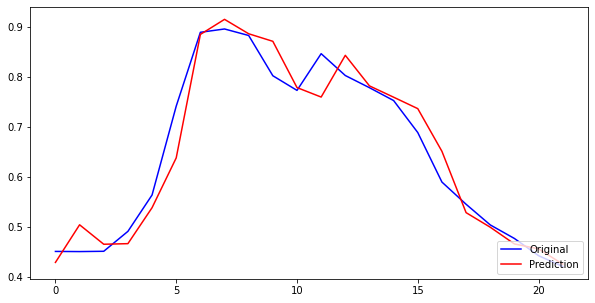

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(new, 'b', label='Original')
ax1.plot(yhat, 'r', label='Prediction')
ax1.legend(loc="lower right")